In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import tensorflow_datasets as tfds
import numpy as np

import matplotlib.pyplot as plt

2022-02-14 18:04:06.963896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 18:04:06.963920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')
train, val, test = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

BATCH_SIZE = 32
IMAGE_SIZE = 224

2022-02-14 18:04:08.799099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 18:04:08.799497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 18:04:08.799542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-14 18:04:08.799582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-14 18:04:08.799622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [3]:
@tf.function
def process_img(img, label):
    return tf.image.resize(img, (224, 224)) / 255., label

def prepare_ds(train, val, test, num_examples, process_fn, batch_size):
    train_ds = train.map(process_img).shuffle(num_examples).batch(batch_size)
    val_ds = val.map(process_img).batch(batch_size)
    test_ds = test.map(process_img).batch(batch_size)

    return train_ds, val_ds, test_ds

In [4]:
train_ds, val_ds, test_ds = prepare_ds(train, val, test, num_examples, process_img, BATCH_SIZE)

In [5]:
model = tf.keras.models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

In [6]:
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
val_loss = tf.keras.losses.SparseCategoricalCrossentropy()

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [8]:
EPOCHS = 2

def train_one_step(model, optimizer, x, y, train_loss, train_acc):

    with tf.GradientTape() as tape:
        preds = model(x)
        loss = train_loss(y, preds)

    grads = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_acc(y, preds)

    return loss

@tf.function
def train_model(model, optimizer, epochs, train_ds, val_ds, train_loss_obj, train_acc, val_loss_obj, val_acc):

    step = 0
    train_loss = 0.
    val_loss = 0.
    for epoch in range(epochs):
        for x, y in train_ds:
            step += 1
            train_loss = train_one_step(model, optimizer, x, y, train_loss_obj, train_acc)

            tf.print('Step', step, ': train_loss =', train_loss, 'train_acc =' , train_acc.result())

        for x, y in val_ds:
            y_pred = model(x)
            val_loss = val_loss_obj(y, y_pred)
            val_acc(y, y_pred)

        tf.print(f'Epoch', epoch, ': train_loss =', train_loss, 'train_acc =', train_acc.result(), 'val_loss =', val_loss, 'val_acc =', val_acc.result())

In [9]:
train_model(model, optimizer, EPOCHS, train_ds, val_ds, train_loss, train_accuracy, val_loss, val_accuracy)

Step 1 : train_loss = 0.675483823 train_acc = 0.71875
Step 2 : train_loss = 195.667099 train_acc = 0.59375
Step 3 : train_loss = 70.7385788 train_acc = 0.572916687
Step 4 : train_loss = 88.8426819 train_acc = 0.5390625
Step 5 : train_loss = 100.939346 train_acc = 0.53125
Step 6 : train_loss = 57.2702827 train_acc = 0.526041687
Step 7 : train_loss = 9.63779831 train_acc = 0.517857134
Step 8 : train_loss = 30.538868 train_acc = 0.515625
Step 9 : train_loss = 54.2248535 train_acc = 0.517361104
Step 10 : train_loss = 72.6591 train_acc = 0.503125
Step 11 : train_loss = 65.3465 train_acc = 0.488636374
Step 12 : train_loss = 35.4717865 train_acc = 0.494791657
Step 13 : train_loss = 16.5029869 train_acc = 0.5
Step 14 : train_loss = 2.85984635 train_acc = 0.517857134
Step 15 : train_loss = 9.76334 train_acc = 0.514583349
Step 16 : train_loss = 10.8365269 train_acc = 0.517578125
Step 17 : train_loss = 21.3196125 train_acc = 0.514705896
Step 18 : train_loss = 21.9693565 train_acc = 0.506944418
St

In [11]:
test_imgs = []
test_labels = []

predictions = []
for images, labels in test_ds:
    preds = model(images)
    preds = preds.numpy()
    predictions.extend(preds)

    test_imgs.extend(images.numpy())
    test_labels.extend(labels.numpy())

In [12]:
class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # print the true label first
    print(true_label)
  
    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

1


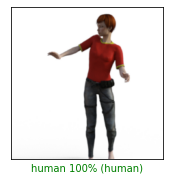

In [31]:
index = np.random.randint(255)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()